목표: 80%정도의 정확도를 VGG와 ResNet을 이용해서 90%이상으로 끌어올려보자.

진행순서 <br>
Step1: 실험환경 Set-up <br>
    -  Batch size, Epoch등을 변경 <br>
Step2: 데이터 준비하기 <br>
    - 원본 데이터를 가져와서 전처리 및 배치 구성을 진행 <br>
    - 의료 영상 이미지의 특성상 데이터는 언제나 충분하지 않다 => Data Augment기법 고려 (<-- 항상 도움이 되는 건 아니지만..) <br>
Step3: 데이터 시각화 <br>
    - 학습용 데이터 시각화 <br> 
Step4: ResMet-18구현 <br> 
    - Convolution filter,채널 개수, activation, 모델 구조등을 다양하게 바꿀 수 있음 <br>
    - 1. 3*3 CNN <br>
    - 2. BatchNormalization <br>
    - 3. 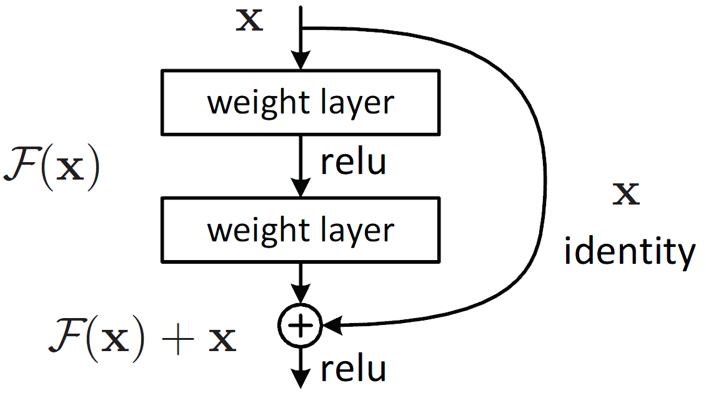 <br>
Step5: 데이터 imbalance 처리 <br>
Step6: 모델 훈련 <br>
    - optimizer나 learning rate등의 변화를 고려할 수 있음 <br>
Step7: 결과 확인과 시각화 <br>
    - accuracy뿐만 아니라 recall도 <br>
    - 훈련과정의 history도 그래프로 시각화 <br>
    - 학습진행 양상을 분석 <br>

In [29]:
# 데이터셋 불러올용
import os, re
from tensorflow.keras.preprocessing import image_dataset_from_directory
import pandas as pd

# 데이터 시각화용
import matplotlib.pyplot as plt
import random, math

# 모델학습용
from tensorflow import keras
from tensorflow.keras import layers, backend, regularizers, initializers, models, Model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, GlobalAveragePooling2D, BatchNormalization, Layer, Add
from keras.models import Sequential

import tensorflow as tf
print(tf.__version__)

2.6.0


In [2]:
os.getcwd()

'/aiffel/aiffel/workplace/Aiffel_Quest/MainQuest'

In [3]:
# data_path = os.getenv("HOME")+'/aiffel/workplace/Aiffel_Quest/MainQuest/chest-xray-pneumonia/train'

### Step1. 실험환경 Set-up

In [4]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [360, 360]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경, 기존 코드와는 다르게 변경함
BATCH_SIZE = 24
EPOCHS = 50


print(ROOT_PATH)

/aiffel/aiffel


In [5]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


### Step2. 데이터 준비하기

In [6]:
train_data = image_dataset_from_directory(
            ROOT_PATH+'/chest_xray/data/train/',
            batch_size = BATCH_SIZE,
            image_size = IMAGE_SIZE,
            label_mode='binary'
)

test_data = image_dataset_from_directory(
            ROOT_PATH+'/chest_xray/data/test/',
            batch_size = BATCH_SIZE,
            image_size = IMAGE_SIZE,
            label_mode='binary'
)

val_data = image_dataset_from_directory(
            ROOT_PATH+'/chest_xray/data/val/',
            batch_size = BATCH_SIZE,
            image_size = IMAGE_SIZE,
            label_mode='binary'
)

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


<BatchDataset shapes: ((None, 360, 360, 3), (None, 1)), types: (tf.float32, tf.float32)>


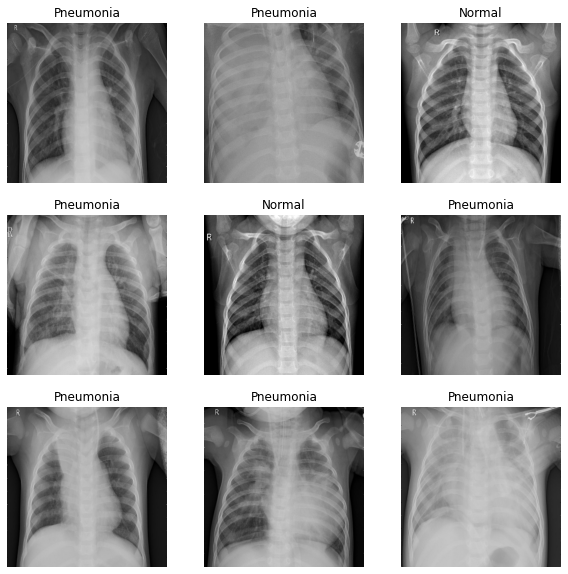

In [7]:
# 이미지 데이터셋이 잘 호출됐는지 확인용
print(train_data)
class_names = ['Normal', 'Pneumonia']

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

In [8]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1341
Pneumonia images count in training set: 3875


In [9]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [10]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 5216
Validating images count: 16


In [11]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [12]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [13]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [14]:
# 2-1에 있던 코드, 데이터를 augment함
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

# 이 방법도 이따 model 학습때 사용해볼것
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomTranslation(0.1, 0.1)
])


def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

print(train_ds)
print(val_ds)

<PrefetchDataset shapes: ((None, 360, 360, 3), (None,)), types: (tf.float32, tf.bool)>
<PrefetchDataset shapes: ((None, 360, 360, 3), (None,)), types: (tf.float32, tf.bool)>


### Step3. 데이터 시각화

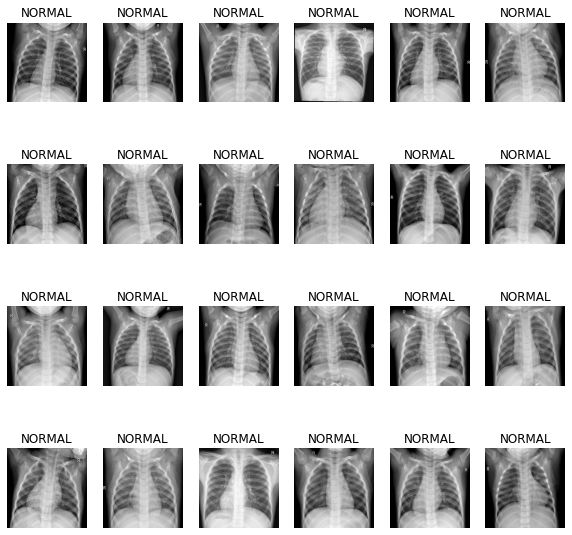

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
# training 이전에 데이터 시각화 해보기
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

normal만 많이 보이는 것이 이상하다, 데이터의 분포를 봐줘야 될 거 같다. step5에서 imablance를 처리해 줘야될것 같다.

In [16]:
# image_batch.numpy().nunique() 
label_batch.numpy() # 전부 false
label_batch

<tf.Tensor: shape=(24,), dtype=bool, numpy=
array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])>

### Step4. ResNet-18 구현

In [17]:
# block 안에 반복적으로 활용되는 L2 regularizer를 선언해 줍니다.
def _gen_l2_regularizer(use_l2_regularizer=True, l2_weight_decay=1e-4):
    return regularizers.l2(l2_weight_decay) if use_l2_regularizer else None

print('Resnet50 GoGo!!')

Resnet50 GoGo!!


In [22]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [19]:
# # Q. conv_block 함수를 가져옵니다.
# def conv_block(input_tensor,
#                kernel_size,
#                filters,
#                stage,
#                block,
#                strides=(2, 2),
#                use_l2_regularizer=True,
#                batch_norm_decay=0.9,
#                batch_norm_epsilon=1e-5):
    
#     filters1, filters2, filters3 = filters 
#     if backend.image_data_format() == "channels_last":
#         bn_axis = 3
#     else:
#         bn_axis = 1
#     conv_name_base = 'res' + str(stage) + block() + '_branch'
#     bn_name_base = 'bn' + str(stage) + block + '_branch'


#     return x

In [20]:
# # Q. identity_block을 가져옵니다.
# def identity_block(input_tensor,
#                    kernel_size,
#                    filters,
#                    stage,
#                    block,
#                    use_l2_regularizer=True,
#                    batch_norm_decay=0.9,
#                    batch_norm_epsilon=1e-5):

#     filters1, filters2, filters3 = filters 
#     if backend.image_data_format() == "channels_last":
#         bn_axis = 3
#     else:
#         bn_axis = 1
#     conv_name_base = 'res' + str(stage) + block + "_branch"
#     bnn_name_base = 'bn' + str(stage) + block + '_branch'
#     return x

In [24]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv1 = conv_block(5),
        conv2_x = conv_block(64),
        conv3_x = conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv4_x = conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

SyntaxError: invalid syntax (1631020126.py, line 9)

In [ ]:
inputs = keras.Input((7, 7, 1))

In [30]:
def resnet18(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)
#     x = layers.Rescaling(1./255)(x)
    x = layers.Conv2D(64, 7, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
#     x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = residual_block(x, 8, 3)
    x = residual_block(x, 8, 3)
    x = residual_block(x, 8, 3)

    x = residual_block(x, 16, 3, strides=2)
    x = residual_block(x, 16, 3)
    x = residual_block(x, 16, 3)
    x = residual_block(x, 16, 3)

    x = residual_block(x, 32, 3, strides=2)
    x = residual_block(x, 32, 3)
    x = residual_block(x, 32, 3)
    x = residual_block(x, 32, 3)
    x = residual_block(x, 32, 3)
    x = residual_block(x, 32, 3)

    x = residual_block(x, 64, 3, strides=2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 64, 3)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, x)
    return model


def residual_block(x, filters, kernel_size, strides=1):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    if strides != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=strides, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

In [ ]:
# Q. resnet18 함수를 가져옵니다.
def resnet18(num_classes, batch_size=None, use_l2_regularizer=True, rescale_inputs=False, 
             batch_norm_decay=0.9, batch_norm_epsilon=1e-5):



    input_shape = (32, 32, 3)
    img_input = layers.Input(shape=input_shape, batch_size=batch_size)

    if backend.image_data_format() == 'channels_first':
        x = layers.Lambda(
            lambda x: backend.permute_dimensions(x, (0, 3, 1, 2)),
            name='transpose')(img_input)
        bn_axis = 1
    else:  # channels_last
        x = img_input
        bn_axis = 3

    x = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(x)
    x = layers.Conv2D(
        64, (7, 7),
        strides=(2, 2),
        padding='valid',
        use_bias=False,
        kernel_initializer='he_normal',
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name='conv1')(x)
    x = layers.BatchNormalization(
        axis=bn_axis,
        momentum=batch_norm_decay,
        epsilon=batch_norm_epsilon,
        name='bn_conv1')(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)




    rm_axes = [1, 2] if backend.image_data_format() == 'channels_last' else [2, 3]
    x = layers.Lambda(lambda x: backend.mean(x, rm_axes), name='reduce_mean')(x)
    x = layers.Dense(
        num_classes,
        kernel_initializer = initializers.RandomNormal(stddev=0.01),
        bias_regularizer = _gen_l2_regularizer(use_l2_regularizer),
        name = 'fc1000')(x)

    x = layers.Activation('softmax', dtype='float32')(x)
    
    return models.Model(img_input, x, name='resnet50')

In [31]:

class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

### Step5. 데이터 imbalance처리

In [ ]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

### Step6. 모델 훈련

In [ ]:
model = resnet18(num_classes=100)

# model
model.summary()

In [33]:
model = ResNet18(10)
model.build(input_shape = (None,32,32,3))
#use categorical_crossentropy since the label is one-hot encoded
from tensorflow.keras.optimizers import SGD
# opt = SGD(learning_rate=0.1,momentum=0.9,decay = 1e-04) #parameters suggested by He [1]
model.compile(optimizer = "adam",loss='categorical_crossentropy', metrics=["accuracy"]) 
model.summary()

Model: "res_net18_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           multiple                  9472      
_________________________________________________________________
batch_normalization_20 (Batc multiple                  256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
resnet_block_8 (ResnetBlock) multiple                  74368     
_________________________________________________________________
resnet_block_9 (ResnetBlock) multiple                  74368     
_________________________________________________________________
resnet_block_10 (ResnetBlock multiple                  231296    
_________________________________________________________________
resnet_block_11 (ResnetBlock multiple                  